1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
%matplotlib inline 
df=pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col=0)
df.head()

/Users/apple/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/Users/apple/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df = df.replace(['Yes'], 1).replace(['No'], 0) 
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

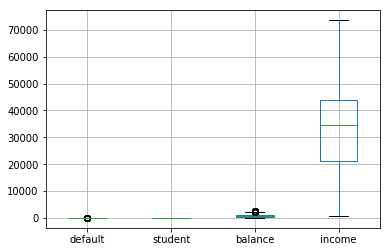

In [64]:
df.boxplot()

In [65]:
colors=df["default"]
colors=colors.replace(1,"r").replace(0,"b")

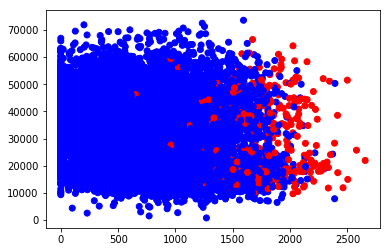

In [66]:
plt.scatter(df['balance'],df['income'],c=colors)

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

(0, 70000)

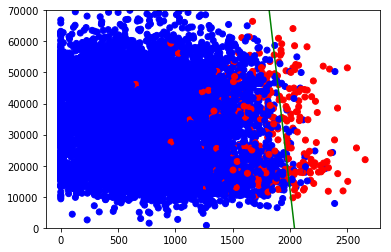

In [67]:
X=df[['balance','income']]
y=df['default']
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
lr=LogisticRegression(penalty='l1')
lr.fit(X_train, y_train)
coef=lr.coef_
a=coef[0]
b=lr.intercept_
x=np.arange(0, 2600, 1)
y=(b+a[0]*x)/-a[1]
plt.scatter(df['balance'],df['income'],c=colors)
plt.plot(x, y,c='g')
plt.ylim(0, 70000)

Area under the ROC curve : 0.960734


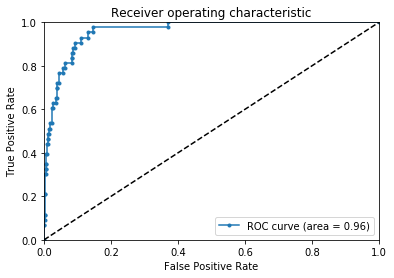

In [4]:
X=df[['balance','income']]
y=df['default']
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Area under the ROC curve : 0.962037


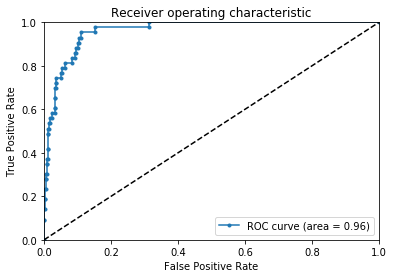

In [84]:
X=df[['balance','income','student']]
y=df['default']
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

('The coefficients:', array([ 0.06472572,  0.00296429, -0.00483573]))


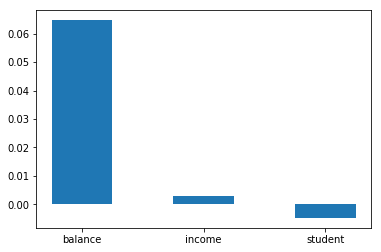

In [83]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
X=df[['balance','income','student']]
y=df['default']
scaler=StandardScaler()
X=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

alphas=np.logspace(-5, -1, 100)
score=[]
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income','student'))
rects = ax.patches
print ('The coefficients:',clf.coef_)


The ROC increases from 0.960749 to 0.962023. This is not a big change. 

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

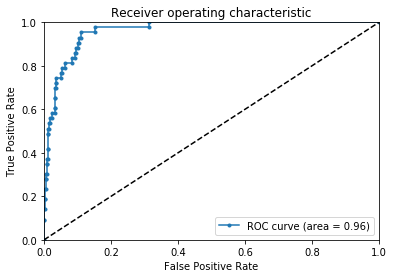

The ROC curve for random state is: 5


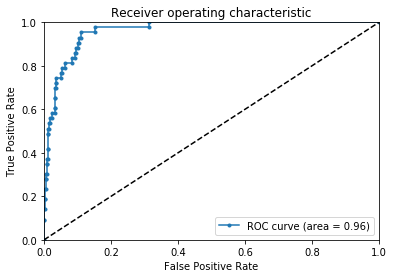

The ROC curve for random state is: 10


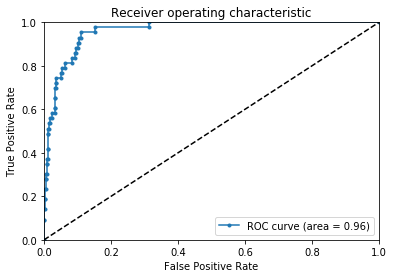

The ROC curve for random state is: 20


In [87]:
random_states=[5,10,20]
for random_state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    clf = LogisticRegression(penalty='l1', C=alphas[opt_index])
    clf.fit(X_train, y_train)
    generate_ROCplot(fpr,tpr,'LR',roc_auc)
    print "The ROC curve for random state is:", random_state

Obviously, the model is pretty robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [6]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

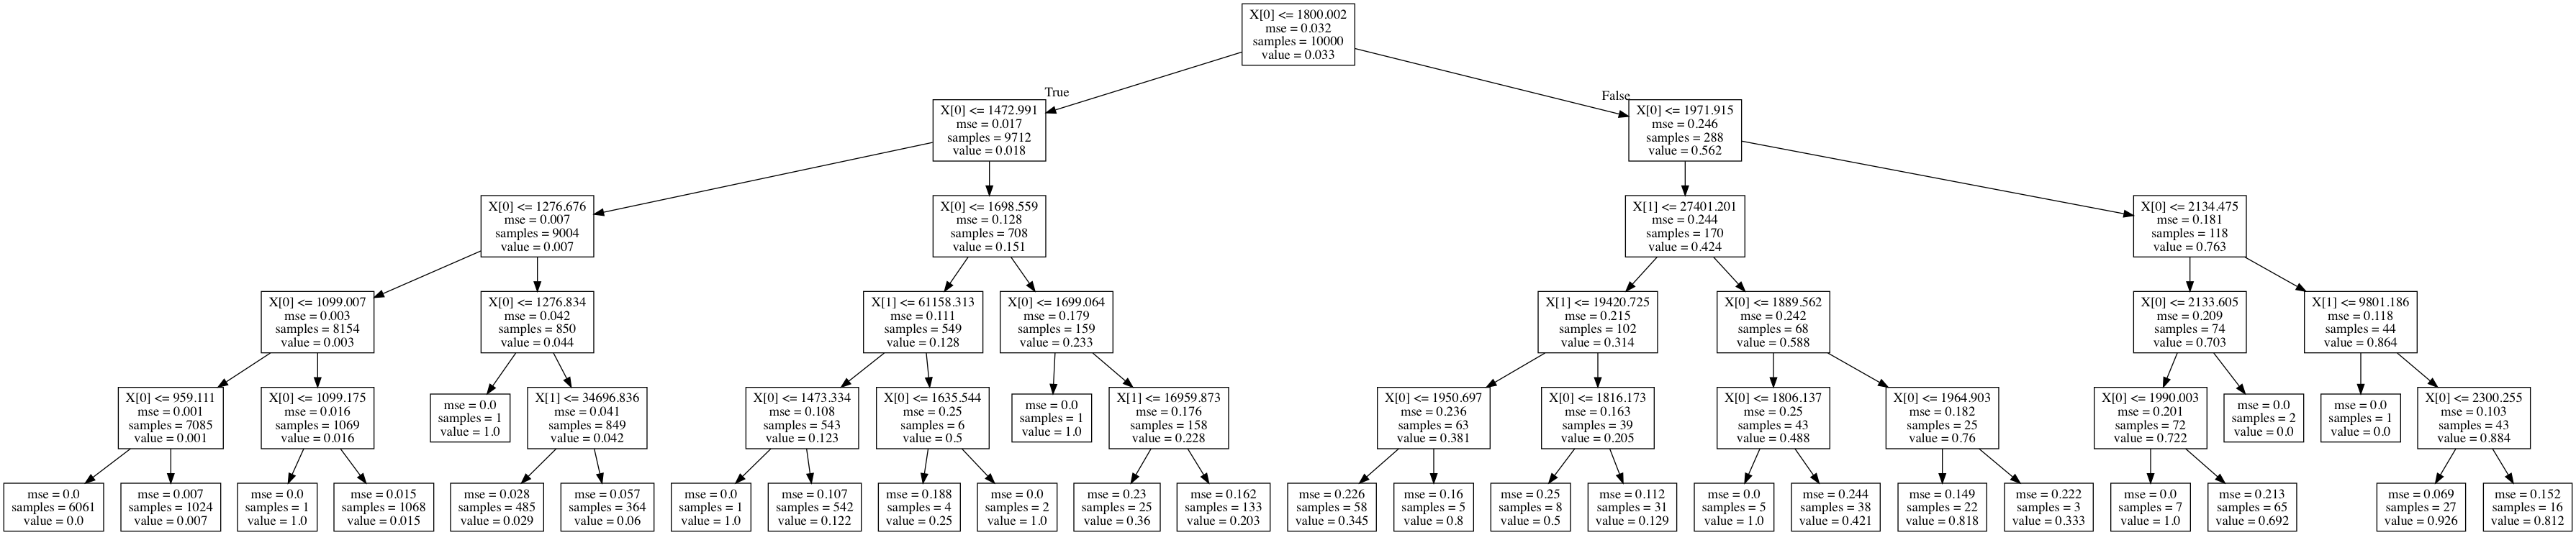

In [7]:
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
regr = DecisionTreeRegressor(max_depth=5)
regr.fit(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr, feature_names=['x'])
dot_data=export_graphviz(regr, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

8) Find the optimal decision tree depth and compute the AUC ROC. 

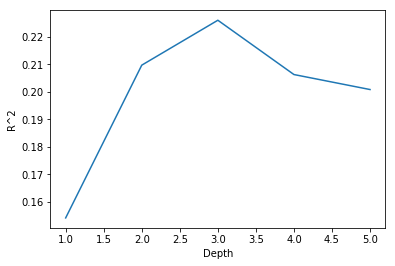

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]

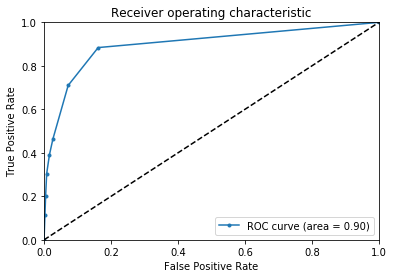

In [12]:
regr_opt = DecisionTreeRegressor(max_depth=n_opt)
regr_opt.fit(X_train, y_train)

y_pred = regr_opt.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
generate_ROCplot(fpr,tpr,'Decision Tree',roc_auc)

The AUC is 0.9, perform worse than Logistic regression